In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
dir_name = '/content/drive/MyDrive/Colab Notebooks/Suicide_prediction_directly(5-31-2023)/'

In [ ]:
train_df_feature = np.load(dir_name + "train_feature_male.npy")
test_df_feature = np.load(dir_name + "test_feature_male.npy")

hospitalizations_label_train = np.load(dir_name + "train_label_hospitalizations_male.npy")
timeto1stHosp_label_train = np.load(dir_name + "train_label_timeto1stHosp_male.npy")

hospitalizations_label_test = np.load(dir_name + "test_label_hospitalizations_male.npy")
timeto1stHosp_label_test = np.load(dir_name + "test_label_timeto1stHosp_male.npy")

In [ ]:
train_df_feature_remove_nan = np.load(dir_name + "train_feature_male.npy")
test_df_feature_remove_nan = np.load(dir_name + "test_feature_male.npy")

hospitalizations_label_train_remove_nan = np.load(dir_name + "train_label_hospitalizations_male.npy")
timeto1stHosp_label_train_remove_nan = np.load(dir_name + "train_label_timeto1stHosp_male.npy")

hospitalizations_label_test_remove_nan = np.load(dir_name + "test_label_hospitalizations_male.npy")
timeto1stHosp_label_test_remove_nan = np.load(dir_name + "test_label_timeto1stHosp_male.npy")

In [ ]:
def return_sequential_model_timeto1stHosp():#timeto1sthosp val_accuracy: 0.8538 - val_auc: 0.7551
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)])
  return model

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
   dir_name + "model/timeto1stHosp_male.h5", save_best_only = True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_auc", patience = 100)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_timeto1stHosp = return_sequential_model_timeto1stHosp()
model_timeto1stHosp.compile(optimizer=optimizer,loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', tf.keras.metrics.Precision()])
# history=model_timeto1stHosp.fit(train_df_feature_remove_nan, timeto1stHosp_label_train_remove_nan,
#           validation_data=(test_df_feature_remove_nan, timeto1stHosp_label_test_remove_nan), epochs=200, batch_size=16, callbacks  = [checkpoint_cb, early_stopping_cb])
# _, acc, auc = model_timeto1stHosp.evaluate(test_df_feature, timeto1stHosp_label_test)
# print('Accuracy: %.2f' % (acc*100), 'AUC: %.2f' % (auc*100))
# val_acc=history.history['val_accuracy']
# val_auc=history.history['val_auc']
#print ('AUC: %.2f' % (max(val_auc)*100))

test

In [ ]:
model_timeto1stHosp.load_weights(dir_name + "model/timeto1stHosp_male.h5")
_, acc, auc, ppv = model_timeto1stHosp.evaluate(test_df_feature_remove_nan, timeto1stHosp_label_test_remove_nan)

18/18 [==============================] - 1s 3ms/step - loss: 0.4027 - accuracy: 0.8491 - auc: 0.6956 - precision: 0.8729


In [ ]:
def NormalizeData(data): # saliency map code
    return (data - np.min(data)) / (np.max(data) - np.min(data))
saliency_map_list=[]
X_test=test_df_feature_remove_nan
for index in range(len(X_test)):
  # images = X_test[index].reshape((1, *X_test[2].shape))
  images = X_test[index:index+1]
  images = tf.Variable(images, dtype=float)

  with tf.GradientTape() as tape:
      pred = model_timeto1stHosp(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]
      # loss =tf.Variable(1.122, dtype=float)

  grads = tape.gradient(loss, images)
  dgrad_abs = tf.math.abs(grads)
  saliency_map_list.append(dgrad_abs)
saliency_map = np.asanyarray(saliency_map_list)
saliency_map_mean = np.mean(saliency_map, axis=0)[0]
saliency_map_normalize = saliency_map_mean/sum(saliency_map_mean)
saliency_map_normalize=NormalizeData(saliency_map_normalize)


In [ ]:
dir_name = '/content/drive/MyDrive/Colab Notebooks/Suicide_prediction_directly(5-31-2023)/'
columns = pd.read_excel(dir_name + 'Data for USC (ABN RAB 1-8-24).xlsx', sheet_name='Male Discovery', usecols=[*range(4, 39)])
columns = columns.drop(columns=['Number of Hospitalizations in the First Year', 'Time to First Hospitalization (days)', 'Features'])
rename = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Suicide_prediction_directly(5-31-2023)/ProbesetToGeneName.xlsx')
new_columns=[]
j=0
for i in columns:
  buf_in=rename.index[rename['Probesets'] == i].to_list()
  if len(buf_in)>0:
      sex_in=rename.iloc[buf_in[0]].at['Name for Figure']
      new_columns.append(sex_in)
  elif j>=1:

      new_columns.append(i.split(' ')[-1])

  else:
      new_columns.append(i)
  j+=1
len(new_columns)

32

In [ ]:
df_saliency = pd.DataFrame(data = saliency_map_normalize,index=new_columns)
df_saliency = df_saliency.drop('Gender')

In [ ]:
df_saliency

,0
HAMDSI,0.263549
Psychiatric,0.200458
Compliance,0.451999
Familial,0.524236
Example,0.670183
Abuse,0.838444
Medical,0.883485
Losses,0.669237
Useless,0.032649
Introverted,0.773450


In [ ]:
top_10 = df_saliency.sort_values(0,ascending = False)[0:10]
top_10
all=df_saliency.sort_values(0,ascending = False)

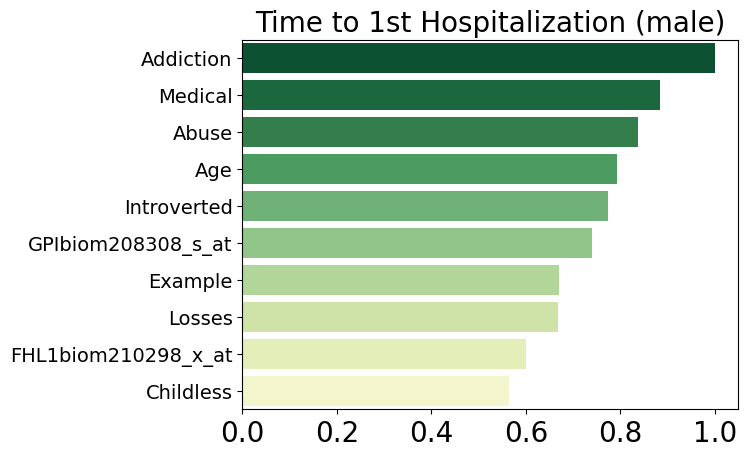

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(data=top_10.T, orient = 'h', palette=sns.color_palette("YlGn_r", 10))#YlGn_r #Blues #YlOrRd_r
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.title('Time to 1st Hospitalization (male)', fontdict={'fontsize': 20})
plt.savefig('time_first_hos_top10', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def return_sequential_model():#val_accuracy: 0.8639 - val_auc: 0.7633
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)])
  return model

In [ ]:
# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
   dir_name + "model/first_year_hosipitalization_male.h5", save_best_only = True
)
for i in range(len(hospitalizations_label_train_remove_nan)):
  if hospitalizations_label_train_remove_nan[i]==0:
    hospitalizations_label_train_remove_nan[i]=1
  else:
    hospitalizations_label_train_remove_nan[i]=0
for i in range(len(hospitalizations_label_test_remove_nan)):
  if hospitalizations_label_test_remove_nan[i]==0:
    hospitalizations_label_test_remove_nan[i]=1
  else:
    hospitalizations_label_test_remove_nan[i]=0
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "val_auc", patience = 150)
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model_hospitalization = return_sequential_model()
model_hospitalization.compile(optimizer=optimizer,loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', tf.keras.metrics.Precision()])
history=model_hospitalization.fit(train_df_feature_remove_nan, hospitalizations_label_train_remove_nan,
          validation_data=(test_df_feature_remove_nan, hospitalizations_label_test_remove_nan), epochs=200, batch_size=16,
          callbacks  = [checkpoint_cb, early_stopping_cb],)
## _, acc, auc = model_hospitalization.evaluate(test_df_feature, hospitalizations_label_test)
## print('Accuracy: %.2f' % (acc*100), 'AUC: %.2f' % (auc*100))
# val_acc=history.history['val_accuracy']
# val_auc=history.history['val_auc']
# print ('AUC: %.2f' % (max(val_auc)*100))

Epoch 1/200
 1/14 [=>............................] - ETA: 14s - loss: 1.6648 - accuracy: 0.1875 - auc: 0.4744 - precision_1: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 2s 95ms/step - loss: 0.8184 - accuracy: 0.5622 - auc: 0.4533 - precision_1: 0.7039 - val_loss: 0.5164 - val_accuracy: 0.8509 - val_auc: 0.3072 - val_precision_1: 0.8509
Epoch 2/200
14/14 [==============================] - 0s 9ms/step - loss: 0.6158 - accuracy: 0.7235 - auc: 0.5096 - precision_1: 0.7235 - val_loss: 0.6497 - val_accuracy: 0.7140 - val_auc: 0.4413 - val_precision_1: 0.8411
Epoch 3/200
14/14 [==============================] - 0s 9ms/step - loss: 0.6184 - accuracy: 0.7189 - auc: 0.4939 - precision_1: 0.7243 - val_loss: 0.5301 - val_accuracy: 0.8509 - val_auc: 0.3317 - val_precision_1: 0.8509
Epoch 4/200
14/14 [==============================] - 0s 9ms/step - loss: 0.6183 - accuracy: 0.7235 - auc: 0.4344 - precision_1: 0.7235 - val_loss: 0.5733 - val_accuracy: 0.8491 - val_auc: 0.3873 - val_precision_1: 0.8506
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.6438 - accuracy: 0.6313 - auc: 0.4956 - precision_1

In [ ]:
model_hospitalization.load_weights(dir_name + "model/first_year_hosipitalization_male.h5")
_, acc, auc, ppv = model_hospitalization.evaluate(test_df_feature_remove_nan, hospitalizations_label_test_remove_nan)

18/18 [==============================] - 0s 2ms/step - loss: 0.3966 - accuracy: 0.8509 - auc: 0.6862 - precision_1: 0.8663


In [ ]:
def NormalizeData(data): # saliency map code
    return (data - np.min(data)) / (np.max(data) - np.min(data))
saliency_map_list=[]
X_test=test_df_feature_remove_nan
for index in range(len(X_test)):
  # images = X_test[index].reshape((1, *X_test[2].shape))
  images = X_test[index:index+1]
  images = tf.Variable(images, dtype=float)

  with tf.GradientTape() as tape:
      pred = model_hospitalization(images, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]
      # loss =tf.Variable(1.122, dtype=float)

  grads = tape.gradient(loss, images)
  dgrad_abs = tf.math.abs(grads)
  saliency_map_list.append(dgrad_abs)
saliency_map = np.asanyarray(saliency_map_list)
saliency_map_mean = np.mean(saliency_map, axis=0)[0]
saliency_map_normalize = saliency_map_mean/sum(saliency_map_mean)
saliency_map_normalize=NormalizeData(saliency_map_normalize)


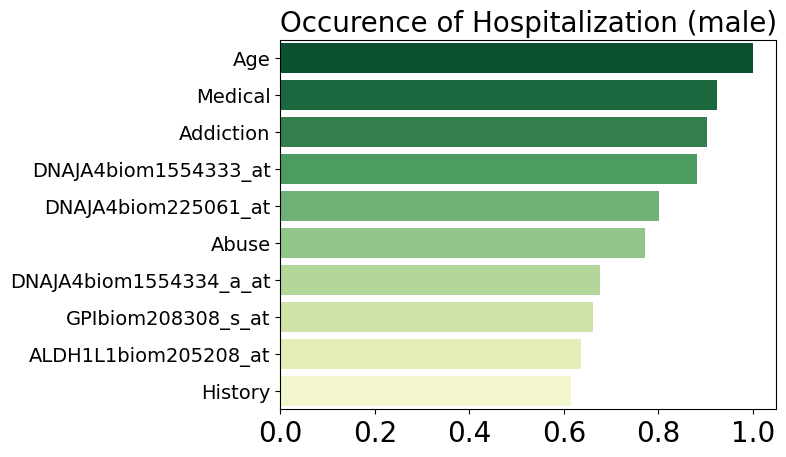

In [ ]:
df_saliency = pd.DataFrame(data = saliency_map_normalize,index=new_columns)
df_saliency = df_saliency.drop('Gender')
top_10 = df_saliency.sort_values(0,ascending = False)[0:10]
top_10
all=df_saliency.sort_values(0,ascending = False)
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(data=top_10.T, orient = 'h', palette=sns.color_palette("YlGn_r", 10))#YlGn_r #Blues #YlOrRd_r
plt.yticks(fontsize=14)
plt.xticks(fontsize=20)
plt.title('Occurence of Hospitalization (male)', fontdict={'fontsize': 20})
plt.savefig('time_first_hos_top10', dpi=300, bbox_inches='tight')
plt.show()